In [10]:
import os
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import glob
from pathlib import Path

def get_patient_folders(base_dir):
    """Get all patient folders in the dataset."""
    # Looking for folders like 'Breast_MRI_001'
    patient_paths = glob.glob(os.path.join(base_dir, "Breast_MRI_*"))
    return sorted(patient_paths)

def get_study_folders(patient_folder):
    """Get all study folders for a patient."""
    # Study folders like '01-01-1990-NA-MRI BREAST BILATERAL WWO-97538'
    study_paths = [os.path.join(patient_folder, d) for d in os.listdir(patient_folder) 
                  if os.path.isdir(os.path.join(patient_folder, d))]
    return sorted(study_paths)

def get_series_folders(study_folder):
    """Get all series folders within a study folder."""
    # Series folders like '3.000000-ax dyn pre-93877'
    series_paths = [os.path.join(study_folder, d) for d in os.listdir(study_folder)
                   if os.path.isdir(os.path.join(study_folder, d))]
    return sorted(series_paths)

def get_dicom_files(series_folder):
    """Get all DICOM files in a series folder."""
    # DICOM files like '1-001.dcm'
    dicom_files = []
    
    # First try files with .dcm extension
    dcm_files = glob.glob(os.path.join(series_folder, "*.dcm"))
    if dcm_files:
        dicom_files.extend(dcm_files)
    else:
        # If no .dcm files found, look for files without extension but with DICOM format
        for file_path in glob.glob(os.path.join(series_folder, "*")):
            if os.path.isfile(file_path):
                try:
                    with open(file_path, 'rb') as f:
                        # Check for DICOM magic bytes
                        f.seek(128)
                        if f.read(4) == b'DICM':
                            dicom_files.append(file_path)
                except:
                    pass
    
    return sorted(dicom_files)

def get_one_image_per_series(patient_folder):
    """Get one representative image from each series folder for a patient."""
    selected_images = []
    series_info = []
    
    # Walk through the directory structure
    for study_path in get_study_folders(patient_folder):
        study_name = os.path.basename(study_path)
        
        for series_path in get_series_folders(study_path):
            series_name = os.path.basename(series_path)
            
            # Extract series description (e.g., "ax dyn pre")
            if '-' in series_name:
                parts = series_name.split('-')
                if len(parts) >= 2:
                    series_desc = parts[1]
                else:
                    series_desc = series_name
            else:
                series_desc = series_name
            
            dicom_files = get_dicom_files(series_path)
            
            if dicom_files:
                # Try to find a middle slice for better representation
                if len(dicom_files) > 2:
                    selected_image = dicom_files[len(dicom_files) // 2]
                else:
                    selected_image = dicom_files[0]
                
                selected_images.append(selected_image)
                series_info.append(series_desc)
    
    return selected_images, series_info

def read_dicom_image(file_path):
    """Read a DICOM file and return the image array and metadata."""
    try:
        dicom = pydicom.dcmread(file_path)
        
        # Get the pixel array (image data)
        image = dicom.pixel_array
        
        # Apply appropriate window/level settings if available
        if hasattr(dicom, 'WindowCenter') and hasattr(dicom, 'WindowWidth'):
            window_center = dicom.WindowCenter
            window_width = dicom.WindowWidth
            
            # Handle both single values and multiple values
            if hasattr(window_center, '__iter__') and not isinstance(window_center, str):
                window_center = window_center[0]
            if hasattr(window_width, '__iter__') and not isinstance(window_width, str):
                window_width = window_width[0]
            
            try:
                # Convert to float to handle string values
                window_center = float(window_center)
                window_width = float(window_width)
                
                # Apply window/level
                min_value = window_center - window_width / 2
                max_value = window_center + window_width / 2
                image = np.clip(image, min_value, max_value)
            except:
                # If conversion fails, just use the raw image
                pass
        
        # Normalize image to 0-1 range for visualization
        if image.max() > image.min():
            image = (image - image.min()) / (image.max() - image.min())
        
        return image, dicom
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None, None

def get_dicom_metadata(dicom):
    """Extract relevant metadata from DICOM file."""
    metadata = {}
    
    if dicom is None:
        return metadata
    
    # Extract important DICOM tags
    try:
        if hasattr(dicom, 'SeriesDescription'):
            metadata['Series'] = dicom.SeriesDescription
        
        if hasattr(dicom, 'InstanceNumber'):
            metadata['Slice'] = dicom.InstanceNumber
        
        if hasattr(dicom, 'SliceLocation'):
            metadata['Location'] = f"{dicom.SliceLocation:.1f}mm"
        
        if hasattr(dicom, 'SliceThickness'):
            metadata['Thickness'] = f"{dicom.SliceThickness}mm"
        
        if hasattr(dicom, 'PixelSpacing'):
            metadata['Resolution'] = f"{dicom.PixelSpacing[0]:.2f}mm"
    except:
        pass
    
    return metadata

def visualize_patient_images(patient_folder, max_images=9):
    """Visualize one image from each series folder for a patient."""
    
    patient_id = os.path.basename(patient_folder)
    print(f"Processing patient: {patient_id}")
    
    selected_images, series_info = get_one_image_per_series(patient_folder)
    
    if not selected_images:
        print(f"No valid DICOM images found for patient {patient_id}")
        return []
    
    # Limit the number of images to display
    if len(selected_images) > max_images:
        # Select a diverse set of series types
        unique_prefixes = {}
        for i, desc in enumerate(series_info):
            prefix = desc.split()[0] if desc and ' ' in desc else desc
            if prefix not in unique_prefixes and len(unique_prefixes) < max_images:
                unique_prefixes[prefix] = i
        
        selected_indices = list(unique_prefixes.values())
        
        # Fill remaining slots with other images
        remaining = max_images - len(selected_indices)
        if remaining > 0:
            other_indices = [i for i in range(len(selected_images)) if i not in selected_indices]
            selected_indices.extend(other_indices[:remaining])
        
        selected_indices.sort()
        selected_images = [selected_images[i] for i in selected_indices]
        series_info = [series_info[i] for i in selected_indices]
    
    # Calculate grid dimensions
    grid_size = int(np.ceil(np.sqrt(len(selected_images))))
    
    # Create a figure with subplots - increase figure size for more title space
    fig, axes = plt.subplots(2, grid_size, figsize=(16, 8))
    if grid_size == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, (image_path, series_desc) in enumerate(zip(selected_images, series_info)):
        image_data, dicom = read_dicom_image(image_path)
        
        if image_data is not None:
            # Display the image
            axes[i].imshow(image_data, cmap='gray')
            
            # Get metadata for display
            metadata = get_dicom_metadata(dicom)
            
            # Create title with series description and metadata
            title = series_desc
            
            # Add relevant metadata to title
            if 'Slice' in metadata:
                title += f"\nSlice: {metadata['Slice']}"
            if 'Location' in metadata:
                title += f" ({metadata['Location']})"
            
            # Add file path as footnote (shortened)
            rel_path = os.path.relpath(image_path, patient_folder)
            footnote = f"{os.path.join('...', rel_path)}"
            
            # Set title with more padding/space
            axes[i].set_title(title, fontsize=10, pad=10)  # Increased padding
            # axes[i].text(0.5, -0.05, footnote, fontsize=8, ha='center', 
            #              transform=axes[i].transAxes, alpha=0.7)
            axes[i].axis('off')
    
    # Hide empty subplots
    for j in range(len(selected_images), 2 * grid_size):
        axes[j].axis('off')
    
    # Add more space between subplots
    plt.suptitle(f"Sample Images for {patient_id}", fontsize=16, y=0.98, pad=10)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94, hspace=0.25, wspace=0.25)  # Increased spacing
    
    # Save the figure if needed
    # plt.savefig(f"{patient_id}_images.png", dpi=150, bbox_inches='tight')
    
    plt.show()
    
    return selected_images
    

Found 1 patient folders
Processing patient folder: ../data/Duke-Breast-Cancer-MRI/Breast_MRI_358
Processing patient: Breast_MRI_358


AttributeError: 'Text' object has no property 'pad'

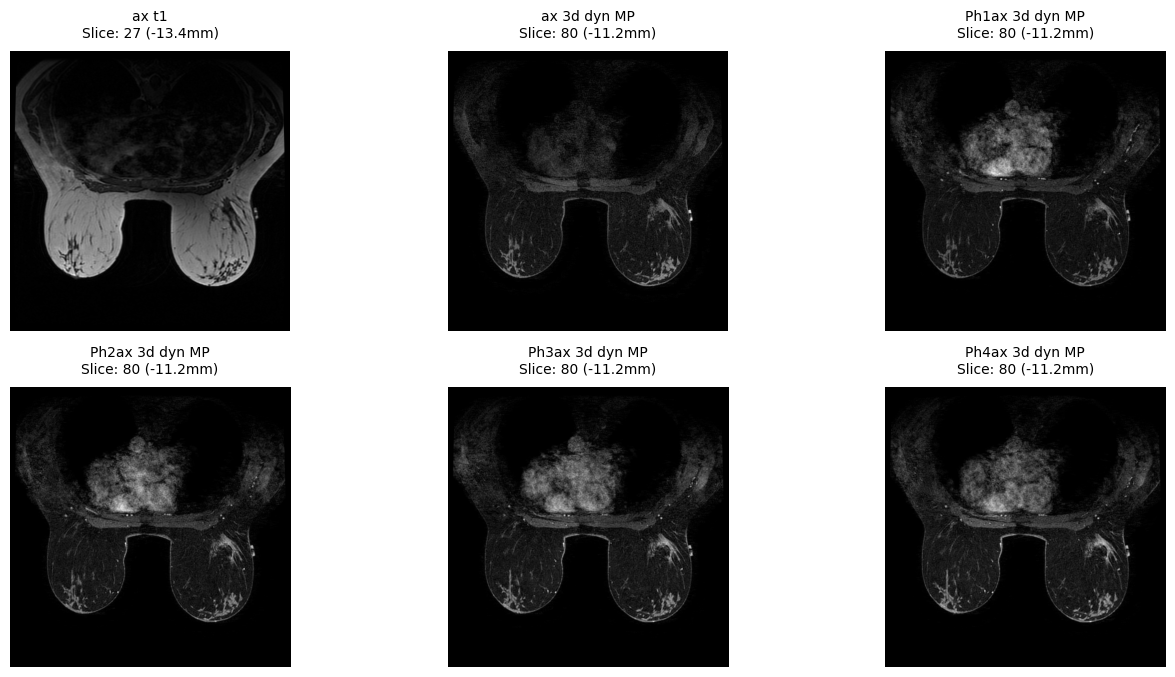

In [11]:
"""Main function to process the dataset."""
# Update this path to your dataset location
base_dir = "../data/Duke-Breast-Cancer-MRI"

# Get all patient folders
patient_folders = get_patient_folders(base_dir)

if not patient_folders:
    print(f"No patient folders found in {base_dir}")


print(f"Found {len(patient_folders)} patient folders")

# Process the first patient as an example
# You can change the index to process a different patient
patient_folder = patient_folders[0]
print(f"Processing patient folder: {patient_folder}")

# Visualize images for this patient
selected_images = visualize_patient_images(patient_folder)

# Print paths of selected images
print("\nSelected image paths:")
for i, path in enumerate(selected_images):
    print(f"{i+1}. {path}")